In [51]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import random
from time import time
from tqdm import tqdm

In [52]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [53]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.show()
    
def plotPartResult(np_dots, cycles,i=0):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    #plt.savefig(f'plots/{i}.png')
    plt.show()    
    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [54]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random(dataset_choice="kroa"):
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)
    candidates=np.arange(0,100,1)
    #print(candidates)
    cycles={}
    cycles[0]=[randrange(100)]
    candidates=np.delete(candidates, cycles[0][0])
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]
    candidates=np.delete(candidates, cycles[1][0])
    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        chosenElementIndex = np.random.randint(len(candidates))
        #print(chosenElementIndex,len(candidates),candidates[chosenElementIndex])
        #cycles[chosenCycle]=np.insert(cycles[chosenCycle],candidates[chosenElementIndex])
        cycles[chosenCycle]=np.concatenate((cycles[chosenCycle], [candidates[chosenElementIndex]]), axis=0)
        candidates=np.delete(candidates, chosenElementIndex)
    return cycles


In [40]:
# 1st variable - Start cycle - with nearest neighbour method
def starty_cycle_heuristic(dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(100)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
#     print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
#     print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
        plt.clf()
        plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
        plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
        plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [180]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = starty_cycle_heuristic()
        
    print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    print(f"Initial distance: {bestDistance}")
    
    plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        

        for move, edges in possible_moves:
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internal=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
                break
    
    plotPartResult(np_dots, cycles)
    plt.show()
    
    

In [8]:
# 2nd variable - Find more optimal solution
def steep_search(cycleA, cycleB):
    raise NotImplementedError

In [111]:
# 3rd variable - Generate neighbour solution
#changes vertex internally or externaly between cycles
def change_vertices(cycles, a, b, internally=True):
    if internally:
#         print(len(np.where(cycles[0] == a)))
#         print(np.where(cycles[0] == a))
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
        #print(cycles[0][inB], cycles[0][inA])
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
        #pass
    #print(cycles)
    return cycles
    #if aIndex in cycles[0]
    #raise NotImplementedError

In [179]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycles, edge1, edge2, internal=False): # dummy internal
    cI= 0 if len(np.where(cycles[0] == edge1)[0])!=0 else 1 
#     print(cycles[cI])
    inA=np.where(cycles[cI] == edge1)[0][0]
    inB=np.where(cycles[cI] == edge2)[0][0]
    inA += 1
    inB += 1
    cycle = cycles[cI]
    cycle[inA: inB] = np.flip(cycle[inA: inB])
    return cycles

In [46]:
# algorytm losowego bładzenia który robi losowo wybrany ruch jako punkt odniesienia wzgledem rozwiazan steep search i greedy search
def random_wandering(dist, np_dots, duration, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = starty_cycle_heuristic()
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
#     print(f"Initial distance: {bestDistance}")
    
#     plotPartResult(np_dots, cycles)
    
    startTime = time()
    done = False
    while not done:
        done = True
        while True:
            if random.random() > 0.5:
                cycle = 0
            else:
                cycle = 1

            if random.random() > 0.5:
                edge1 = random.randint(0, 49)
                edge2 = random.randint(edge1, 49)
#                 print(edge1, edge2)
                internal_change(cycles[cycle], edge1, edge2)
            else:
    #             change_vertices()
                pass
#             plotPartResult(np_dots, cycles)
#             currentDistance = 0
#             currentDistance += calcDistance(cycles[0], dist)
#             currentDistance += calcDistance(cycles[1], dist)
            if time() - startTime > duration:
                break
                done = False
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    
    currentDistance = 0
    currentDistance += calcDistance(cycles[0], dist)
    currentDistance += calcDistance(cycles[1], dist)
    return currentDistance






  0%|          | 0/100 [00:00<?, ?it/s]

{0: array([ 1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53, 39, 63, 68, 80,
       24, 92, 66, 27, 57, 60, 50, 86,  8, 34, 76, 44, 22, 59, 61, 85, 26,
       42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34965.191109869265


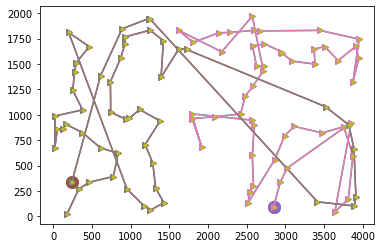

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


New best distance: 34728.24773140617, changed 51 with 4 on external
New best distance: 34699.861954112224, changed 65 with 17 on internal
New best distance: 34690.68256962139, changed 97 with 81 on internal
New best distance: 34655.983685032625, changed 93 with 21 on internal
New best distance: 34326.0484620624, changed 40 with 70 on internal
New best distance: 33954.74186247094, changed 98 with 18 on internal
New best distance: 33283.8664106396, changed 72 with 6 on internal
New best distance: 33277.799313148185, changed 72 with 8 on internal
New best distance: 33181.93603572593, changed 98 with 71 on internal
New best distance: 33180.24761310929, changed 57 with 92 on internal
New best distance: 33119.913046307025, changed 8 with 6 on internal
New best distance: 32805.618968044415, changed 65 with 69 on internal
New best distance: 32743.361089704835, changed 4 with 36 on internal
New best distance: 32533.5606431563, changed 71 with 35 on internal
New best distance: 32346.145932312756

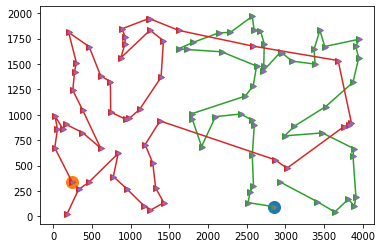






  1%|          | 1/100 [00:07<12:58,  7.86s/it]

{0: array([75, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47, 99, 70,
       13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 92, 27, 57,
       60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 12, 81, 94]), 1: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 61, 76, 59, 22, 97, 44, 90, 46,
       31, 10, 73, 20, 71,  9, 89, 48,  5, 62, 66,  0, 91,  7, 41, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17, 23, 37, 35, 98])}
Initial distance: 29534.608876335733


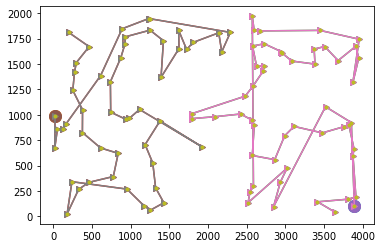

New best distance: 29310.225543452776, changed 75 with 12 on internal
New best distance: 29210.780724243334, changed 92 with 66 on external
New best distance: 29198.5776445905, changed 95 with 1 on internal
New best distance: 29182.905013461757, changed 62 with 0 on internal
New best distance: 29091.45662227227, changed 63 with 50 on internal
New best distance: 28877.212064437063, changed 66 with 92 on external
New best distance: 28842.513179848298, changed 93 with 21 on internal
New best distance: 28789.89835076031, changed 12 with 94 on internal
New best distance: 28549.030329677862, changed 87 with 52 on internal
New best distance: 28536.937762630027, changed 40 with 99 on internal
New best distance: 27900.50139346817, changed 53 with 1 on internal
New best distance: 27899.2831575553, changed 22 with 61 on internal
New best distance: 27879.912754539924, changed 81 with 77 on internal
New best distance: 27756.962018804556, changed 70 with 40 on internal
New best distance: 27600.15039

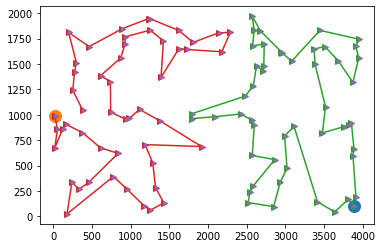






  2%|▏         | 2/100 [00:14<12:04,  7.40s/it]

{0: array([46, 92,  1, 43, 49, 29, 51, 75, 81, 94, 12, 32, 36,  4, 77, 95, 38,
       84, 67, 72, 53, 39, 63, 68, 80, 24, 34, 85, 19, 56,  6,  8, 86, 50,
       60, 57, 27, 18, 74, 65, 25, 64,  3, 96, 55, 79, 30, 88, 41, 66]), 1: array([47, 99, 76, 44, 16, 14, 93, 69, 21, 15, 87, 52, 78, 17, 23, 37, 98,
       35, 83,  7, 91,  0, 62,  5, 48, 89,  9, 71, 20, 58, 73, 10, 31, 90,
       97, 22, 59, 61, 26, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 31728.164819789352


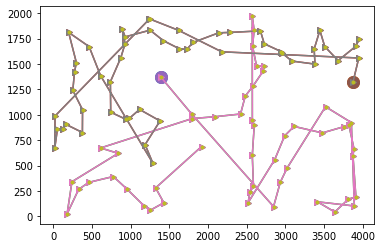

New best distance: 31571.183275757998, changed 99 with 28 on internal
New best distance: 31490.331570996284, changed 0 with 7 on internal
New best distance: 31462.615342646255, changed 92 with 57 on internal
New best distance: 31410.335719862996, changed 10 with 58 on internal
New best distance: 31300.057569973796, changed 47 with 13 on internal
New best distance: 31265.292448687294, changed 12 with 81 on internal
New best distance: 31233.98528470831, changed 39 with 1 on internal
New best distance: 31198.835590510862, changed 13 with 28 on internal
New best distance: 31160.924265330068, changed 50 with 34 on internal
New best distance: 31102.799930019777, changed 31 with 93 on internal
New best distance: 30933.14075825769, changed 51 with 95 on internal
New best distance: 30818.840081377475, changed 83 with 62 on internal
New best distance: 30672.47090117069, changed 63 with 72 on internal
New best distance: 30267.549525938262, changed 38 with 29 on internal
New best distance: 30115.2

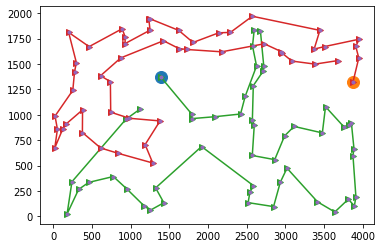






  3%|▎         | 3/100 [00:19<11:07,  6.88s/it]

{0: array([34, 76, 44, 22, 59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28,
       33, 82, 54, 11, 19, 56,  6,  8, 86,  1, 43, 49, 51, 94, 12, 36, 95,
       38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34931.29833544009


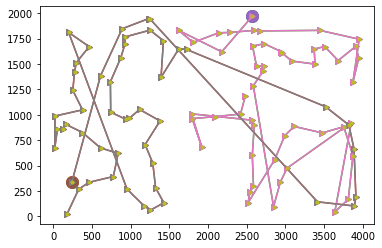

New best distance: 34884.9466129637, changed 65 with 18 on internal
New best distance: 34819.16588201319, changed 73 with 81 on internal
New best distance: 34733.3522241668, changed 24 with 50 on internal
New best distance: 34587.22536665611, changed 37 with 98 on internal
New best distance: 34561.245812454654, changed 95 with 4 on external
New best distance: 33907.746280636515, changed 86 with 72 on internal
New best distance: 33234.06083591123, changed 51 with 81 on external
New best distance: 32976.6136421241, changed 57 with 66 on internal
New best distance: 32742.404095796323, changed 73 with 46 on internal
New best distance: 32505.92410677512, changed 95 with 51 on internal
New best distance: 32226.069449366798, changed 73 with 58 on internal
New best distance: 31896.134226396563, changed 40 with 70 on internal
New best distance: 31893.16455783348, changed 89 with 83 on internal
New best distance: 31473.00097618675, changed 22 with 92 on internal
New best distance: 30712.43714107

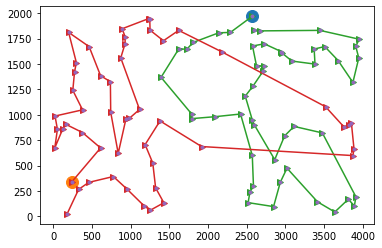






  4%|▍         | 4/100 [00:26<10:39,  6.67s/it]

{0: array([98, 35, 37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 83, 58, 16, 14,
       97, 44, 90, 46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62,  0, 91,  7,
       41, 75, 32, 12, 94, 81, 88, 30, 79, 55, 65, 25, 64,  3, 96, 74]), 1: array([47, 99, 34, 76, 22, 59, 61, 85, 26,  1, 43, 49, 29, 51, 36,  4, 77,
       95, 38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50,
       86,  8,  6, 56, 19, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 33039.62894418322


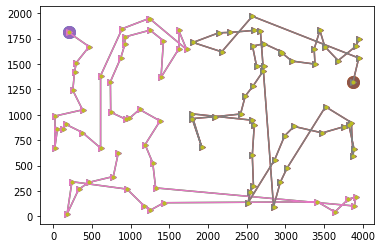

New best distance: 32935.764402085704, changed 26 with 19 on internal
New best distance: 32863.96338289786, changed 55 with 25 on internal
New best distance: 32462.827729398487, changed 83 with 74 on internal
New best distance: 32443.663648620066, changed 31 with 97 on internal
New best distance: 32213.838941316128, changed 99 with 40 on internal
New best distance: 32130.804742330016, changed 11 with 6 on internal
New best distance: 32074.94894653579, changed 8 with 1 on internal
New best distance: 31856.51519394073, changed 45 with 34 on internal
New best distance: 31854.241581872513, changed 60 with 92 on internal
New best distance: 31821.155132308566, changed 31 with 90 on internal
New best distance: 31807.538668690322, changed 81 with 75 on internal
New best distance: 31798.013840280517, changed 2 with 45 on internal
New best distance: 31752.105540437202, changed 95 with 36 on internal
New best distance: 31741.01264168707, changed 17 with 83 on internal
New best distance: 31070.866

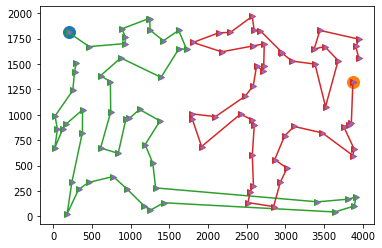






  5%|▌         | 5/100 [00:33<10:51,  6.86s/it]

{0: array([93, 69, 21, 15, 98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 97, 44, 90,
       46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 75, 32,
       12, 94, 81, 88, 30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87]), 1: array([47, 99, 34, 76, 22, 59, 61, 85, 26,  1, 43, 49, 29, 51, 36,  4, 77,
       95, 38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50,
       86,  8,  6, 56, 19, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 32312.446900465282


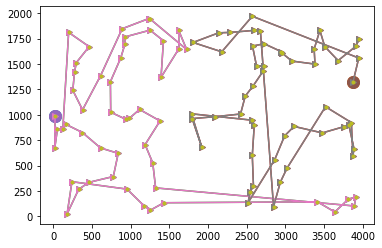

New best distance: 32263.835155554, changed 51 with 95 on internal
New best distance: 32097.14018077679, changed 99 with 45 on internal
New best distance: 31966.66811144087, changed 84 with 29 on internal
New best distance: 31962.90243872725, changed 99 with 28 on internal
New best distance: 31668.164017950807, changed 99 with 40 on internal
New best distance: 31654.547554332567, changed 41 with 94 on internal
New best distance: 31352.85420671379, changed 26 with 11 on internal
New best distance: 31318.089085427288, changed 94 with 75 on internal
New best distance: 30815.8056327839, changed 72 with 1 on internal
New best distance: 30558.358438996773, changed 57 with 66 on internal
New best distance: 30304.903238625717, changed 14 with 44 on internal
New best distance: 30228.622843315236, changed 55 with 96 on internal
New best distance: 30226.34923124702, changed 60 with 92 on internal
New best distance: 30103.4550606254, changed 49 with 67 on internal
New best distance: 30038.38793364

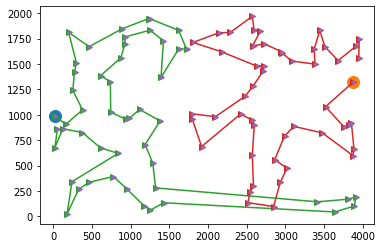






  6%|▌         | 6/100 [00:41<11:23,  7.27s/it]

{0: array([44, 16, 14, 83, 98, 35, 37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18,
       74, 65, 25, 64,  3, 96, 55, 79, 30, 88, 41,  7, 91, 92,  0, 62,  5,
       48, 89,  9, 71, 20, 58, 73, 10, 46, 31, 90, 61, 76, 59, 22, 97]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 28879.429799493017


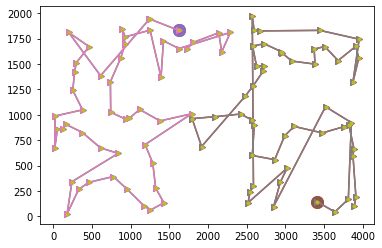

New best distance: 28834.34366793595, changed 50 with 57 on internal
New best distance: 28799.644783347183, changed 93 with 21 on internal
New best distance: 28798.337968906293, changed 14 with 9 on internal
New best distance: 28576.258412626878, changed 63 with 68 on internal
New best distance: 28556.124348033292, changed 44 with 14 on internal
New best distance: 28447.314398883787, changed 60 with 34 on internal
New best distance: 28442.39643343039, changed 60 with 86 on internal
New best distance: 28361.314904131017, changed 19 with 34 on internal
New best distance: 28191.525297224056, changed 90 with 76 on internal
New best distance: 28171.310519753213, changed 24 with 50 on internal
New best distance: 28126.367203024103, changed 16 with 58 on internal
New best distance: 28118.464791090253, changed 12 with 77 on internal
New best distance: 28084.211559845142, changed 77 with 51 on internal
New best distance: 27966.587820256595, changed 50 with 56 on internal
New best distance: 2795

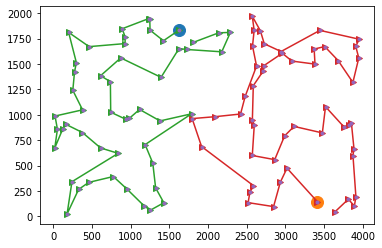






  7%|▋         | 7/100 [00:48<10:56,  7.06s/it]

{0: array([ 1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53, 39, 63, 68, 80,
       24, 92, 66, 27, 57, 60, 50, 86,  8, 34, 76, 44, 22, 59, 61, 85, 26,
       42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34965.191109869265


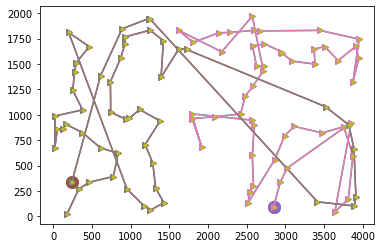

New best distance: 34924.27955221258, changed 51 with 36 on internal
New best distance: 34597.802089614226, changed 55 with 96 on internal
New best distance: 34503.175354938096, changed 24 with 60 on internal
New best distance: 34458.26220172407, changed 8 with 26 on internal
New best distance: 34381.34854851636, changed 37 with 98 on internal
New best distance: 34260.86995417297, changed 84 with 6 on internal
New best distance: 34227.35258407876, changed 80 with 67 on internal
New best distance: 33733.05378602981, changed 72 with 68 on internal
New best distance: 33710.04899530302, changed 84 with 26 on internal
New best distance: 33668.37997677909, changed 85 with 76 on internal
New best distance: 33326.4099834867, changed 14 with 90 on internal
New best distance: 32953.10693666183, changed 84 with 54 on internal
New best distance: 32819.41505530997, changed 49 with 84 on internal
New best distance: 32762.278499944812, changed 21 with 35 on internal
New best distance: 32732.934736966

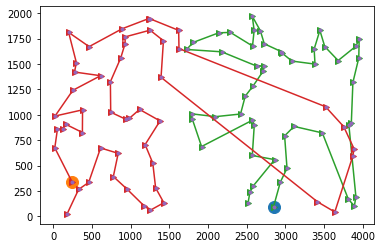






  8%|▊         | 8/100 [00:54<10:20,  6.74s/it]

{0: array([34, 76, 44, 22, 59, 61, 85, 26,  1, 43, 49, 51, 94, 12, 36, 95, 38,
       84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50, 86,  8,
        6, 56, 19, 11, 54, 82, 33, 28, 45, 40, 47, 99, 70, 13,  2, 42]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 35027.621381584264


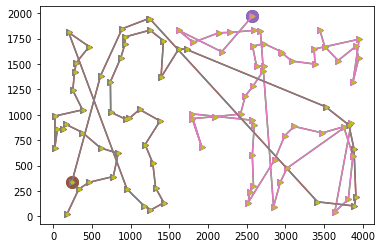

New best distance: 35026.67392921381, changed 26 with 8 on internal
New best distance: 35026.01192795989, changed 38 with 51 on internal
New best distance: 34968.12528646877, changed 45 with 47 on internal
New best distance: 34966.43686385213, changed 57 with 92 on internal
New best distance: 34698.977513245714, changed 55 with 78 on internal
New best distance: 33747.8758207357, changed 65 with 55 on internal
New best distance: 33646.10436568591, changed 40 with 70 on internal
New best distance: 33471.3056194899, changed 34 with 26 on internal
New best distance: 33452.106857579674, changed 0 with 81 on internal
New best distance: 32781.23140574833, changed 53 with 1 on internal
New best distance: 32781.23140574832, changed 65 with 25 on internal
New best distance: 32648.7584991178, changed 95 with 4 on external
New best distance: 32572.478103807327, changed 96 with 55 on internal
New best distance: 32572.478103807323, changed 65 with 74 on internal
New best distance: 32558.12798106912,

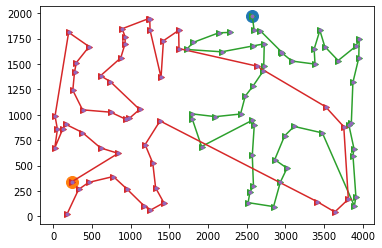






  9%|▉         | 9/100 [01:01<10:40,  7.04s/it]

{0: array([16, 14, 61, 76, 59, 22, 97, 44, 90, 46, 31, 83, 98, 35, 37, 23, 17,
       78, 93, 69, 21, 15, 87, 52, 18, 74, 65, 25, 64,  3, 96, 55, 79, 30,
       88, 41,  7, 91, 92,  0, 62,  5, 48, 89,  9, 71, 20, 58, 73, 10]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 28837.8512510344


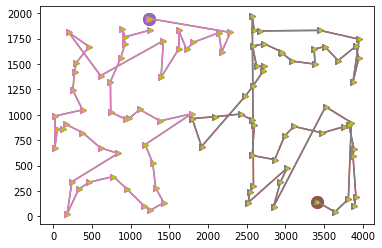

New best distance: 28620.479537979205, changed 63 with 54 on internal
New best distance: 28434.795088128412, changed 83 with 35 on internal
New best distance: 28381.013824117203, changed 29 with 75 on internal
New best distance: 28379.79558820433, changed 14 with 59 on internal
New best distance: 28334.709456647266, changed 60 with 66 on internal
New best distance: 27907.55211630853, changed 67 with 54 on internal
New best distance: 27899.662684098264, changed 72 with 49 on internal
New best distance: 27839.92325316165, changed 42 with 34 on internal
New best distance: 27469.846559277386, changed 49 with 43 on internal
New best distance: 27185.042466575032, changed 51 with 95 on internal
New best distance: 27157.196467087786, changed 83 with 9 on internal
New best distance: 27145.103900039947, changed 70 with 47 on internal
New best distance: 27111.62787261881, changed 14 with 97 on internal
New best distance: 27089.154385115136, changed 14 with 90 on internal
New best distance: 27033.

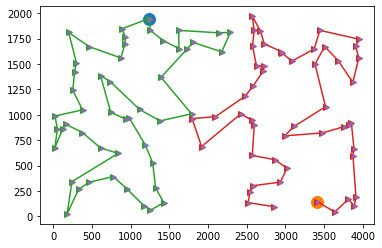






 10%|█         | 10/100 [01:07<09:45,  6.51s/it]

{0: array([46, 92, 18, 74, 65, 25, 64,  3, 96, 55, 79, 30, 88, 41, 66,  1, 43,
       49, 29, 51, 75, 81, 94, 12, 32, 36,  4, 77, 95, 38, 84, 67, 72, 53,
       39, 63, 68, 80, 24, 34, 85, 19, 56,  6,  8, 86, 50, 60, 57, 27]), 1: array([47, 99, 76, 44, 16, 14, 93, 69, 21, 15, 87, 52, 78, 17, 23, 37, 98,
       35, 83,  7, 91,  0, 62,  5, 48, 89,  9, 71, 20, 58, 73, 10, 31, 90,
       97, 22, 59, 61, 26, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 31147.543279781476


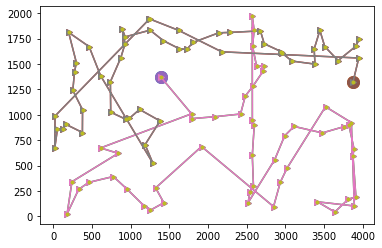

New best distance: 31133.657715969555, changed 14 with 89 on internal
New best distance: 31047.01347779385, changed 24 with 60 on internal
New best distance: 30877.35430603177, changed 51 with 95 on internal
New best distance: 30729.318278310264, changed 36 with 81 on internal
New best distance: 30324.396903077835, changed 49 with 75 on internal
New best distance: 30306.355732192864, changed 44 with 14 on internal
New best distance: 29991.967654760847, changed 18 with 7 on external
New best distance: 29974.886265811685, changed 92 with 57 on internal
New best distance: 29749.618288744292, changed 17 with 93 on internal
New best distance: 29747.459140953943, changed 18 with 9 on internal
New best distance: 29694.124258580807, changed 94 with 75 on internal
New best distance: 29662.547595553922, changed 92 with 27 on internal
New best distance: 29573.17469292933, changed 77 with 51 on internal
New best distance: 29566.940723932465, changed 99 with 54 on internal
New best distance: 29289.

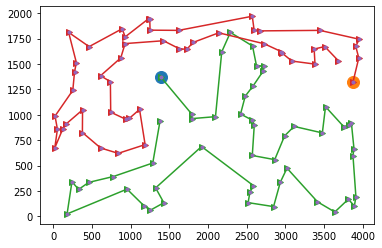






 11%|█         | 11/100 [01:12<09:16,  6.25s/it]

{0: array([ 1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53, 39, 63, 68, 80,
       24, 34, 76, 44, 22, 59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45,
       28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 92, 66, 27, 57, 60]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34837.688393216245


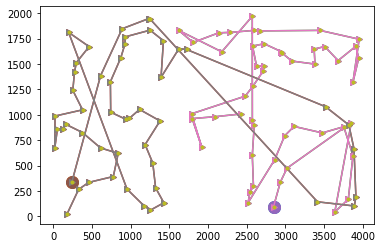

New best distance: 34828.85214294412, changed 55 with 37 on internal
New best distance: 34787.21279833326, changed 24 with 85 on internal
New best distance: 34778.03341384243, changed 14 with 29 on internal
New best distance: 34772.32408156619, changed 63 with 60 on internal
New best distance: 34586.02225655778, changed 63 with 92 on internal
New best distance: 34471.17113900441, changed 19 with 85 on internal
New best distance: 34404.48183623913, changed 55 with 18 on internal
New best distance: 34193.31326472107, changed 94 with 75 on external
New best distance: 34146.77354820898, changed 36 with 32 on external
New best distance: 34105.10452968505, changed 85 with 76 on internal
New best distance: 34070.40564509629, changed 15 with 69 on internal
New best distance: 34058.31307804845, changed 40 with 99 on internal
New best distance: 33933.23775178887, changed 65 with 69 on internal
New best distance: 33671.218651102434, changed 51 with 4 on external
New best distance: 33666.159130270

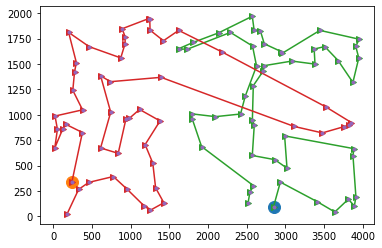






 12%|█▏        | 12/100 [01:20<09:56,  6.78s/it]

{0: array([92, 66, 27,  1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53, 39,
       63, 68, 80, 24, 34, 76, 44, 22, 59, 61, 85, 26, 42, 40, 47, 99, 70,
       13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 60, 57]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34673.43324435942


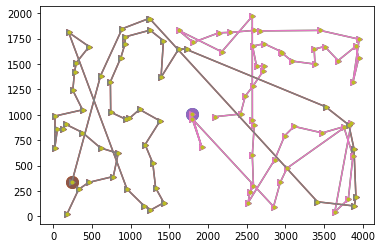

New best distance: 34500.35114877698, changed 65 with 52 on internal
New best distance: 34458.71180416613, changed 24 with 85 on internal
New best distance: 34432.745820822434, changed 65 with 69 on internal
New best distance: 34102.8105978522, changed 40 with 70 on internal
New best distance: 34098.68819512307, changed 48 with 83 on internal
New best distance: 34042.931785381734, changed 27 with 63 on internal
New best distance: 33537.67581914762, changed 98 with 9 on internal
New best distance: 33471.89508819712, changed 73 with 81 on internal
New best distance: 33442.53805928984, changed 24 with 8 on internal
New best distance: 33038.07863349388, changed 73 with 83 on internal
New best distance: 32997.920951076536, changed 76 with 22 on internal
New best distance: 32895.8317207472, changed 27 with 53 on internal
New best distance: 32826.71504192851, changed 20 with 83 on internal
New best distance: 32387.23196476612, changed 51 with 81 on external
New best distance: 31975.2812615504

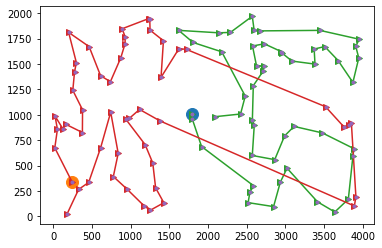






 13%|█▎        | 13/100 [01:26<09:17,  6.41s/it]

{0: array([76, 44, 22, 59,  1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53,
       39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50, 86,  8,  6, 56, 19, 42,
       40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 26, 34, 85, 61]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34798.20123563371


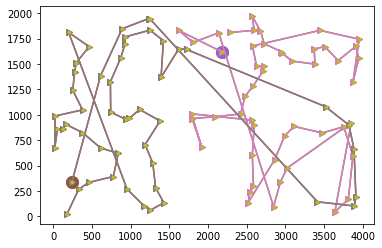

New best distance: 34030.46975623134, changed 51 with 81 on external
New best distance: 33634.012133323915, changed 83 with 55 on internal
New best distance: 33590.8520922658, changed 59 with 60 on internal
New best distance: 33281.25398448178, changed 72 with 1 on internal
New best distance: 33255.27443028032, changed 95 with 4 on external
New best distance: 33244.787765326786, changed 19 with 54 on internal
New best distance: 33224.36045072179, changed 19 with 11 on internal
New best distance: 33160.55899737381, changed 53 with 43 on internal
New best distance: 32987.47690179137, changed 65 with 52 on internal
New best distance: 32884.05055612978, changed 14 with 95 on internal
New best distance: 32778.88205069379, changed 89 with 83 on internal
New best distance: 32777.193628077155, changed 57 with 92 on internal
New best distance: 32602.599025926655, changed 14 with 83 on internal
New best distance: 32052.254141143043, changed 59 with 27 on internal
New best distance: 32050.9473267

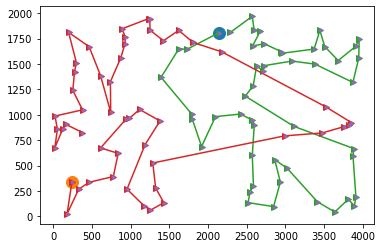






 14%|█▍        | 14/100 [01:33<09:22,  6.54s/it]

{0: array([34, 76, 44, 22, 59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28,
       33, 82, 54, 11, 19, 56,  6,  8, 86,  1, 43, 49, 51, 94, 12, 36, 95,
       38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34931.29833544009


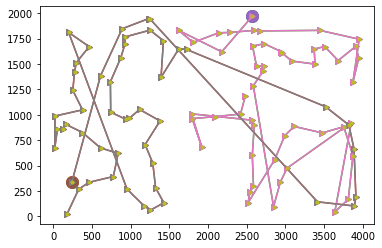

New best distance: 34845.484677593704, changed 24 with 50 on internal
New best distance: 34837.06631670559, changed 89 with 55 on internal
New best distance: 34562.71725776089, changed 89 with 18 on internal
New best distance: 34562.71725776088, changed 34 with 92 on internal
New best distance: 34333.33650294001, changed 65 with 78 on internal
New best distance: 34151.95027211336, changed 83 with 98 on internal
New best distance: 34151.033979180895, changed 55 with 96 on internal
New best distance: 34101.449863902526, changed 87 with 17 on internal
New best distance: 34066.75097931376, changed 93 with 21 on internal
New best distance: 33786.85106990089, changed 65 with 18 on internal
New best distance: 33783.12106711138, changed 9 with 83 on internal
New best distance: 33717.34033616088, changed 14 with 10 on internal
New best distance: 33252.912609946776, changed 18 with 52 on internal
New best distance: 32918.9970521632, changed 73 with 62 on internal
New best distance: 32723.0984651

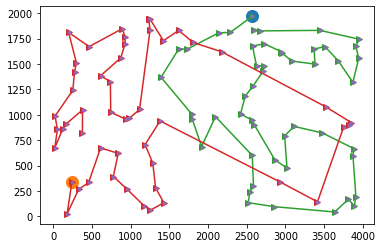






 15%|█▌        | 15/100 [01:39<08:58,  6.33s/it]

{0: array([44, 16, 14, 83, 98, 35, 37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18,
       74, 65, 25, 64,  3, 96, 55, 79, 30, 88, 41,  7, 91, 92,  0, 62,  5,
       48, 89,  9, 71, 20, 58, 73, 10, 46, 31, 90, 61, 76, 59, 22, 97]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 28879.429799493017


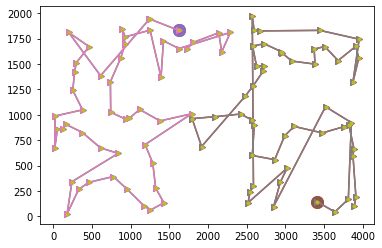

New best distance: 28837.22334253227, changed 63 with 8 on internal
New best distance: 28792.1372109752, changed 50 with 57 on internal
New best distance: 28792.137210975197, changed 81 with 75 on internal
New best distance: 28780.04464392736, changed 40 with 99 on internal
New best distance: 28778.73782948647, changed 14 with 9 on internal
New best distance: 28447.085473706167, changed 67 with 8 on internal
New best distance: 28345.314018656376, changed 13 with 99 on internal
New best distance: 28310.548897369874, changed 81 with 12 on internal
New best distance: 28300.911336854344, changed 90 with 22 on internal
New best distance: 28300.91133685434, changed 44 with 97 on internal
New best distance: 28002.20449680528, changed 29 with 8 on internal
New best distance: 27804.384901588885, changed 83 with 9 on internal
New best distance: 27769.686017000116, changed 15 with 69 on internal
New best distance: 27761.783605066263, changed 12 with 77 on internal
New best distance: 27264.0595286

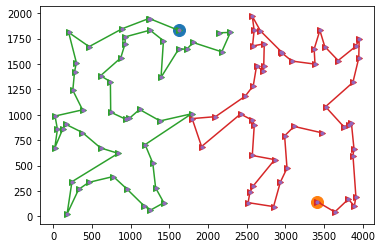






 16%|█▌        | 16/100 [01:44<08:25,  6.02s/it]

{0: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 97, 44, 90, 46, 31, 10, 73, 20,
       71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 75, 32, 12, 94, 81, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 98, 35, 37, 23, 17, 78]), 1: array([47, 99, 34, 76, 22, 59, 61, 85, 26,  1, 43, 49, 29, 51, 36,  4, 77,
       95, 38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50,
       86,  8,  6, 56, 19, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 32638.74510121289


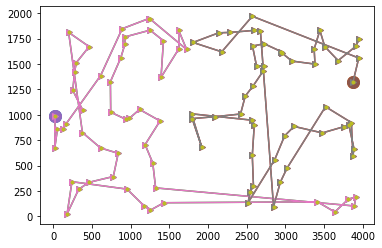

New best distance: 32637.25463769958, changed 41 with 81 on internal
New best distance: 32613.85275479262, changed 99 with 56 on internal
New best distance: 32580.049133524764, changed 94 with 75 on internal
New best distance: 32439.94195335861, changed 99 with 28 on internal
New best distance: 32295.511115917965, changed 26 with 84 on internal
New best distance: 32277.87483748565, changed 77 with 51 on internal
New best distance: 32009.217747839408, changed 29 with 67 on internal
New best distance: 31672.737210723782, changed 24 with 66 on internal
New best distance: 31658.231830102424, changed 52 with 17 on internal
New best distance: 31622.435888273525, changed 33 with 56 on internal
New best distance: 31612.585428349143, changed 23 with 98 on internal
New best distance: 31459.844456415267, changed 87 with 17 on internal
New best distance: 31383.53636557606, changed 33 with 8 on internal
New best distance: 30725.8020124705, changed 53 with 1 on internal
New best distance: 30690.6523

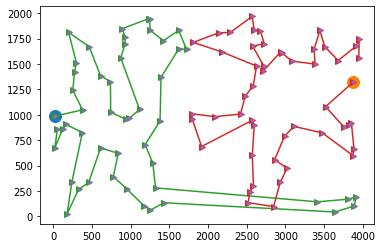






 17%|█▋        | 17/100 [01:51<08:44,  6.32s/it]

{0: array([51, 94, 12, 36, 95, 38, 84, 67, 53, 39, 63, 34, 76, 44, 22, 59, 61,
       85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,
        6,  8, 86, 50, 92, 66, 27, 57, 60, 24, 80, 68, 72, 49, 43,  1]), 1: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90,
       46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17, 23, 37, 35, 98])}
Initial distance: 34191.89657584598


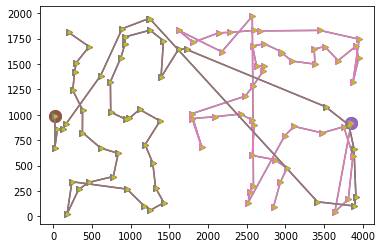

New best distance: 34126.11584489548, changed 14 with 10 on internal
New best distance: 34084.44682637155, changed 34 with 61 on internal
New best distance: 33862.36727009213, changed 63 with 68 on internal
New best distance: 33822.20958767479, changed 76 with 22 on internal
New best distance: 33582.1993619937, changed 87 with 78 on internal
New best distance: 33577.41812521752, changed 67 with 63 on internal
New best distance: 33071.76426803206, changed 85 with 34 on internal
New best distance: 33069.59912473897, changed 96 with 65 on internal
New best distance: 32858.43055322091, changed 94 with 75 on external
New best distance: 32830.83563788295, changed 51 with 77 on external
New best distance: 32814.125341892235, changed 24 with 76 on internal
New best distance: 32749.184378307822, changed 68 with 60 on internal
New best distance: 32668.48476515168, changed 67 with 72 on internal
New best distance: 32666.611526571673, changed 96 with 64 on internal
New best distance: 32448.8152143

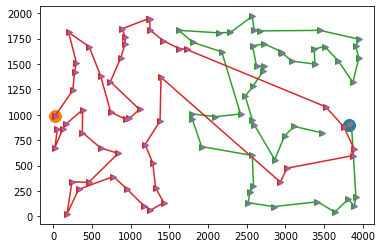






 18%|█▊        | 18/100 [01:56<08:17,  6.07s/it]

{0: array([51, 29,  1, 43, 49, 53, 39, 63, 34, 76, 59, 61, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 75, 32, 36,  4, 77]), 1: array([98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 22, 97, 44, 90, 46, 31, 10,
       73, 20, 71,  9, 89, 48,  5, 62, 12, 94, 81, 92,  0, 91,  7, 41, 88,
       30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87, 15, 93, 21, 69])}
Initial distance: 32749.373170812316


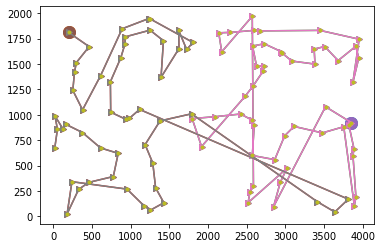

New best distance: 32732.892768344704, changed 62 with 81 on internal
New best distance: 32656.612373034222, changed 55 with 96 on internal
New best distance: 32568.854283823253, changed 50 with 80 on internal
New best distance: 32526.64782686251, changed 63 with 8 on internal
New best distance: 32450.6561720209, changed 66 with 92 on external
New best distance: 31768.24262185167, changed 29 with 49 on internal
New best distance: 31680.852317041456, changed 52 with 69 on internal
New best distance: 31680.85231704145, changed 51 with 77 on internal
New best distance: 31349.199961261154, changed 67 with 8 on internal
New best distance: 31028.19060561261, changed 75 with 49 on internal
New best distance: 31022.92789685639, changed 17 with 87 on internal
New best distance: 31001.275117004658, changed 23 with 83 on internal
New best distance: 30780.414005846156, changed 83 with 78 on internal
New best distance: 30738.74498732223, changed 34 with 61 on internal
New best distance: 30323.34364

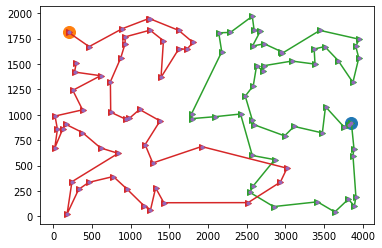






 19%|█▉        | 19/100 [02:03<08:29,  6.29s/it]

{0: array([51, 94, 12, 36, 95, 38, 84, 67, 53, 39, 63, 34, 76, 44, 22, 59, 61,
       85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,
        6,  8, 86, 50, 92, 66, 27, 57, 60, 24, 80, 68, 72, 49, 43,  1]), 1: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90,
       46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17, 23, 37, 35, 98])}
Initial distance: 34191.89657584598


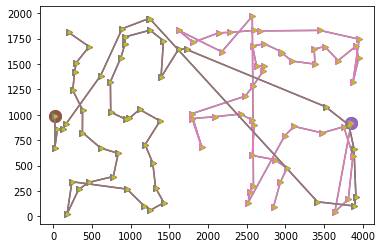

New best distance: 33903.327743505855, changed 51 with 95 on internal
New best distance: 33662.4597224234, changed 87 with 52 on internal
New best distance: 33622.066078089454, changed 31 with 81 on internal
New best distance: 33609.97351104162, changed 40 with 99 on internal
New best distance: 33608.88987998717, changed 63 with 80 on internal
New best distance: 32694.509435821663, changed 94 with 1 on internal
New best distance: 32401.543143768038, changed 68 with 61 on internal
New best distance: 32380.754471988148, changed 3 with 65 on internal
New best distance: 32317.287890630803, changed 68 with 60 on internal
New best distance: 32149.255451610647, changed 68 with 53 on internal
New best distance: 32140.276271435734, changed 80 with 60 on internal
New best distance: 31927.122468260386, changed 72 with 63 on internal
New best distance: 31924.55645050455, changed 63 with 53 on internal
New best distance: 31814.278300615355, changed 13 with 47 on internal
New best distance: 31596.48

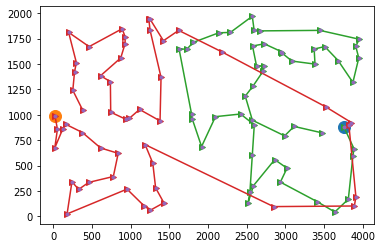






 20%|██        | 20/100 [02:09<08:15,  6.19s/it]

{0: array([34, 76, 44, 22, 59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28,
       33, 82, 54, 11, 19, 56,  6,  1, 43, 49, 51, 94, 12, 36, 95, 38, 84,
       67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50, 86,  8]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34965.19110986928


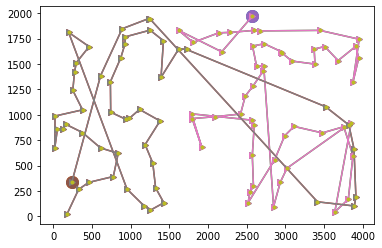

New best distance: 34920.27795665524, changed 26 with 8 on internal
New best distance: 34894.29840245379, changed 95 with 4 on external
New best distance: 34853.90475811984, changed 14 with 46 on internal
New best distance: 34839.55463538164, changed 44 with 97 on external
New best distance: 34827.4620683338, changed 70 with 47 on internal
New best distance: 34799.07629103986, changed 65 with 17 on internal
New best distance: 34676.12555530449, changed 70 with 40 on internal
New best distance: 34637.16477793954, changed 32 with 77 on internal
New best distance: 34594.73307816317, changed 26 with 6 on internal
New best distance: 34027.088361600705, changed 98 with 31 on internal
New best distance: 33831.25928164491, changed 7 with 55 on internal
New best distance: 33597.169653869016, changed 51 with 81 on external
New best distance: 33589.42231342875, changed 98 with 10 on internal
New best distance: 33363.636991966865, changed 6 with 24 on internal
New best distance: 33106.18979817974,

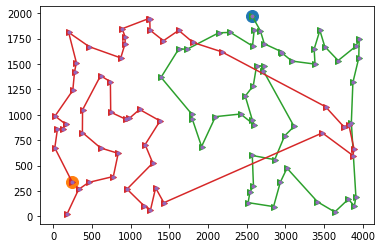






 21%|██        | 21/100 [02:17<08:54,  6.77s/it]

{0: array([98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 97, 44, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 75, 32, 12, 94, 81, 88,
       30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87, 15, 93, 21, 69]), 1: array([47, 99, 34, 76, 22, 59, 61, 85, 26,  1, 43, 49, 29, 51, 36,  4, 77,
       95, 38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50,
       86,  8,  6, 56, 19, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 32319.91680347775


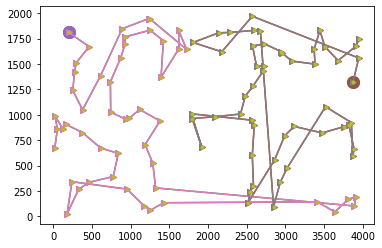

New best distance: 32308.427321871834, changed 99 with 2 on internal
New best distance: 32232.146926561356, changed 55 with 96 on internal
New best distance: 31769.71073546119, changed 72 with 1 on internal
New best distance: 31756.09427184295, changed 41 with 94 on internal
New best distance: 31703.436704181906, changed 99 with 13 on internal
New best distance: 31465.700714291394, changed 43 with 72 on internal
New best distance: 31459.02179361726, changed 93 with 69 on internal
New best distance: 31456.74818154904, changed 24 with 57 on internal
New best distance: 31415.079163025115, changed 34 with 61 on internal
New best distance: 31202.193546202834, changed 15 with 21 on internal
New best distance: 31179.720058699164, changed 14 with 90 on internal
New best distance: 30922.272864912036, changed 57 with 66 on internal
New best distance: 30791.800795576117, changed 84 with 29 on internal
New best distance: 30790.810167268257, changed 13 with 42 on internal
New best distance: 30725.7

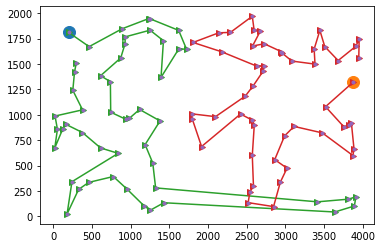






 22%|██▏       | 22/100 [02:23<08:16,  6.36s/it]

{0: array([42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 34, 76, 44, 22, 59, 61,
       85, 26,  1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53, 39, 63,
       68, 80, 24, 92, 66, 27, 57, 60, 50, 86,  8,  6, 56, 19, 11, 54]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 35088.29671324743


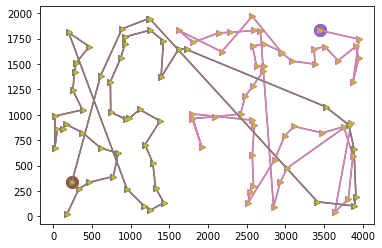

New best distance: 35022.51598229693, changed 14 with 10 on internal
New best distance: 34935.80963826072, changed 82 with 56 on internal
New best distance: 34927.391277372604, changed 89 with 55 on internal
New best distance: 34902.02535678558, changed 1 with 11 on internal
New best distance: 34752.22320698721, changed 67 with 1 on internal
New best distance: 34601.19259647638, changed 33 with 84 on internal
New best distance: 34343.74540268925, changed 92 with 27 on internal
New best distance: 34327.66802135373, changed 33 with 54 on internal
New best distance: 34260.67575194358, changed 71 with 48 on internal
New best distance: 33828.11187621157, changed 83 with 9 on internal
New best distance: 33797.16511258974, changed 33 with 82 on internal
New best distance: 33763.00304207719, changed 67 with 49 on internal
New best distance: 33714.82798497723, changed 54 with 8 on internal
New best distance: 33706.24608342417, changed 45 with 84 on internal
New best distance: 33316.41347288562,

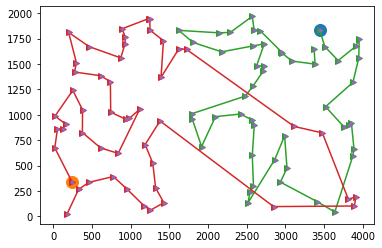






 23%|██▎       | 23/100 [02:29<08:20,  6.49s/it]

{0: array([51, 29,  1, 43, 49, 53, 39, 63, 34, 76, 59, 61, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 75, 32, 36]), 1: array([98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 22, 97, 44, 90, 46, 31, 10,
       73, 20, 71,  9, 89, 48,  5, 62, 12, 94, 81, 92,  0, 91,  7, 41, 88,
       30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87, 15, 69, 21, 93])}
Initial distance: 32551.79238439724


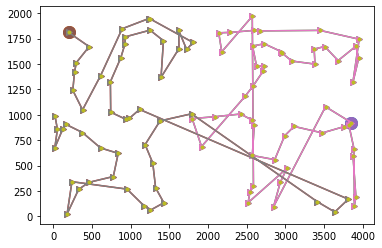

New best distance: 32509.585927436496, changed 63 with 8 on internal
New best distance: 32401.678074732292, changed 19 with 34 on internal
New best distance: 32375.201964229964, changed 62 with 92 on internal
New best distance: 32333.532945706036, changed 34 with 61 on internal
New best distance: 32312.744273926146, changed 55 with 64 on internal
New best distance: 32205.752503759635, changed 63 with 57 on internal
New best distance: 32002.70072634019, changed 14 with 44 on internal
New best distance: 31985.064447907873, changed 51 with 77 on internal
New best distance: 31935.210085962764, changed 26 with 11 on internal
New best distance: 31894.68193780397, changed 19 with 85 on internal
New best distance: 31802.68057440476, changed 95 with 29 on internal
New best distance: 31421.308754352598, changed 63 with 66 on internal
New best distance: 31264.725431717365, changed 29 with 4 on internal
New best distance: 31258.634857848232, changed 54 with 42 on internal
New best distance: 31242.

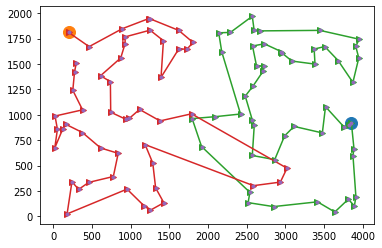






 24%|██▍       | 24/100 [02:36<08:10,  6.45s/it]

{0: array([76, 44, 22, 59,  1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53,
       39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50, 86,  8,  6, 56, 19, 42,
       40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 26, 34, 85, 61]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34798.20123563371


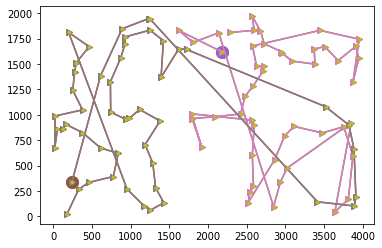

New best distance: 34030.46975623134, changed 51 with 81 on external
New best distance: 33962.62170560467, changed 59 with 50 on internal
New best distance: 33867.99497092854, changed 50 with 92 on internal
New best distance: 33769.59751565662, changed 19 with 11 on internal
New best distance: 33723.24579318022, changed 65 with 18 on internal
New best distance: 33699.363255584176, changed 59 with 57 on internal
New best distance: 33685.013132845976, changed 44 with 97 on external
New best distance: 33680.31555435779, changed 77 with 75 on internal
New best distance: 33673.86970100527, changed 31 with 51 on internal
New best distance: 33593.76439358381, changed 26 with 85 on internal
New best distance: 33593.26737866324, changed 36 with 77 on external
New best distance: 33584.849017775115, changed 98 with 48 on internal
New best distance: 33547.95448504661, changed 60 with 1 on internal
New best distance: 33448.48735715507, changed 29 with 46 on internal
New best distance: 33424.7066779

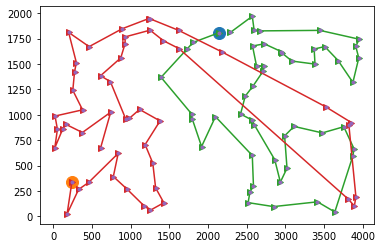






 25%|██▌       | 25/100 [02:40<07:22,  5.90s/it]

{0: array([75, 81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40,
       47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50,
       92, 27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32]), 1: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 61, 76, 59, 22, 97, 44, 90, 46,
       31, 10, 73, 20, 71,  9, 89, 48,  5, 62, 66,  0, 91,  7, 41, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17, 23, 37, 35, 98])}
Initial distance: 29493.988798311133


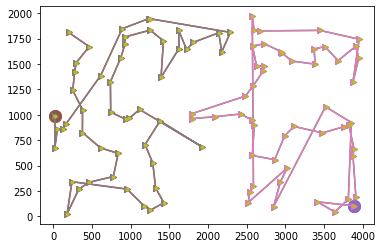

New best distance: 29343.6998237609, changed 29 with 84 on internal
New best distance: 29308.9347024744, changed 75 with 94 on internal
New best distance: 29283.49205097843, changed 42 with 34 on internal
New best distance: 29248.793166389667, changed 93 with 21 on internal
New best distance: 29172.512771079193, changed 55 with 96 on internal
New best distance: 29016.79288916789, changed 14 with 44 on internal
New best distance: 29008.890477234036, changed 12 with 77 on internal
New best distance: 29003.132627956984, changed 63 with 19 on internal
New best distance: 28968.590908152517, changed 63 with 86 on internal
New best distance: 28962.482298862156, changed 63 with 24 on internal
New best distance: 28792.692691955195, changed 59 with 61 on internal
New best distance: 28758.43946071009, changed 77 with 51 on internal
New best distance: 28428.504237739857, changed 40 with 70 on internal
New best distance: 28187.63621665741, changed 87 with 52 on internal
New best distance: 28171.993

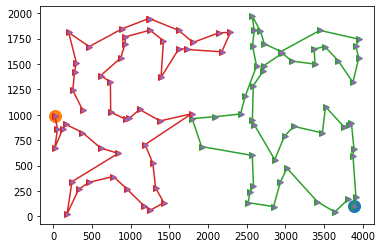






 26%|██▌       | 26/100 [02:47<07:35,  6.15s/it]

{0: array([98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 97, 44, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 75, 32, 12, 94, 81, 88,
       30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87, 93, 69, 21, 15]), 1: array([47, 99, 34, 76, 22, 59, 61, 85, 26,  1, 43, 49, 29, 51, 36,  4, 77,
       95, 38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50,
       86,  8,  6, 56, 19, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 32312.446900465286


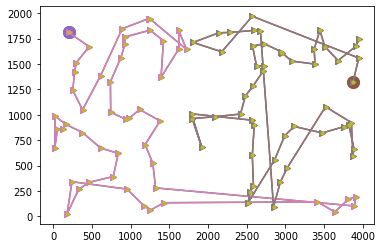

New best distance: 32240.645881277444, changed 55 with 25 on internal
New best distance: 32238.957458660803, changed 24 with 27 on internal
New best distance: 32193.049158817485, changed 51 with 77 on internal
New best distance: 31925.043917695722, changed 26 with 24 on internal
New best distance: 31883.374899171795, changed 34 with 61 on internal
New best distance: 31864.21081839338, changed 14 with 46 on internal
New best distance: 31664.712429144696, changed 14 with 10 on internal
New best distance: 31384.857771736373, changed 83 with 46 on internal
New best distance: 31350.176306697263, changed 76 with 19 on internal
New best distance: 31180.296578941, changed 90 with 97 on internal
New best distance: 31180.296578940997, changed 47 with 40 on internal
New best distance: 31124.54016919966, changed 68 with 1 on internal
New best distance: 30912.445534715713, changed 87 with 15 on internal
New best distance: 30781.973465379793, changed 49 with 38 on internal
New best distance: 30575.6

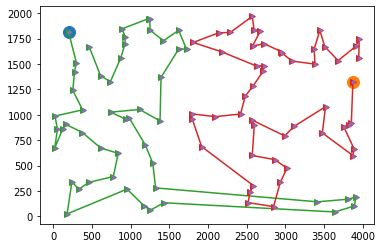






 27%|██▋       | 27/100 [02:55<07:57,  6.53s/it]

{0: array([ 1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 53, 39, 63, 34, 76, 44,
       22, 59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54,
       11, 19, 56,  6,  8, 86, 50, 92, 66, 27, 57, 60, 24, 80, 68, 72]), 1: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90,
       46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17, 23, 37, 35, 98])}
Initial distance: 34117.44607910877


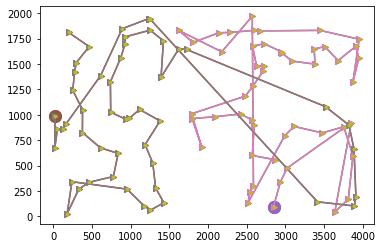

New best distance: 34075.467085600045, changed 63 with 85 on internal
New best distance: 34074.27419677486, changed 49 with 38 on internal
New best distance: 34053.48552499496, changed 55 with 64 on internal
New best distance: 34012.57396733828, changed 95 with 94 on internal
New best distance: 33788.55736716706, changed 63 with 68 on internal
New best distance: 33606.0686518808, changed 94 with 75 on external
New best distance: 33593.18565078422, changed 14 with 97 on internal
New best distance: 33579.68896068541, changed 76 with 97 on external
New best distance: 33449.01482137748, changed 92 with 85 on internal
New best distance: 32163.08482361379, changed 92 with 97 on internal
New best distance: 32139.679268364904, changed 55 with 96 on internal
New best distance: 32091.350404738354, changed 75 with 32 on external
New best distance: 32089.836537776606, changed 36 with 4 on external
New best distance: 32077.43242070751, changed 24 with 50 on internal
New best distance: 31837.4221950

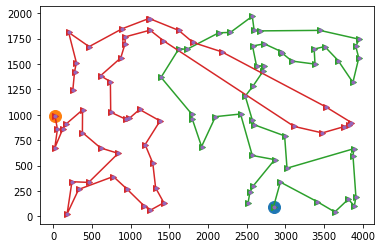






 28%|██▊       | 28/100 [03:01<07:45,  6.46s/it]

{0: array([ 1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53, 39, 63, 34, 76,
       44, 22, 59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82,
       54, 11, 19, 56,  6,  8, 86, 50, 92, 66, 27, 57, 60, 24, 80, 68]), 1: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90,
       46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17, 23, 37, 35, 98])}
Initial distance: 33938.55541568255


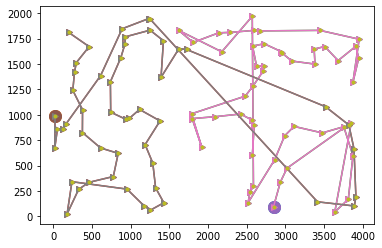

New best distance: 33170.82393628019, changed 51 with 81 on external
New best distance: 33167.06087842754, changed 14 with 77 on internal
New best distance: 33115.226825140184, changed 49 with 68 on internal
New best distance: 33114.14319408574, changed 68 with 34 on internal
New best distance: 32961.402222151846, changed 87 with 17 on internal
New best distance: 32631.46699918162, changed 40 with 70 on internal
New best distance: 32607.923039656685, changed 68 with 26 on internal
New best distance: 32525.227181954004, changed 18 with 65 on internal
New best distance: 32491.230332564177, changed 68 with 8 on internal
New best distance: 32405.030177047673, changed 83 with 98 on internal
New best distance: 32187.233864780985, changed 50 with 66 on internal
New best distance: 32181.309036998806, changed 68 with 24 on internal
New best distance: 31988.76341445835, changed 46 with 77 on internal
New best distance: 31535.250778811765, changed 46 with 75 on internal
New best distance: 31386.7

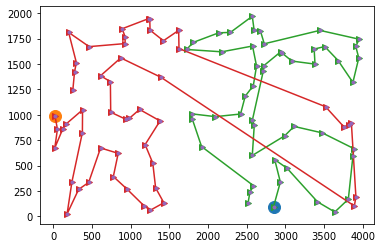






 29%|██▉       | 29/100 [03:07<07:42,  6.52s/it]

{0: array([16, 14, 83, 98, 35, 37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74,
       65, 25, 64,  3, 96, 55, 79, 30, 88, 41,  7, 91, 92,  0, 62,  5, 48,
       89,  9, 71, 20, 58, 73, 10, 61, 76, 59, 22, 97, 44, 90, 31, 46]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 29124.18052639455


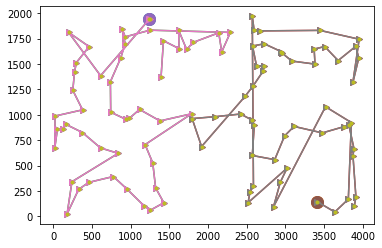

New best distance: 29110.163979812278, changed 14 with 71 on internal
New best distance: 29022.40589060131, changed 50 with 80 on internal
New best distance: 29009.873581230626, changed 14 with 46 on internal
New best distance: 28838.95996627841, changed 63 with 60 on internal
New best distance: 28825.113134417414, changed 61 with 71 on internal
New best distance: 28696.035404356415, changed 44 with 61 on internal
New best distance: 28622.31617871352, changed 14 with 73 on internal
New best distance: 28568.534914702315, changed 29 with 75 on internal
New best distance: 28478.994326948945, changed 81 with 29 on internal
New best distance: 28234.549097204726, changed 50 with 60 on internal
New best distance: 28228.22459926967, changed 51 with 94 on internal
New best distance: 28043.97046663824, changed 68 with 80 on internal
New best distance: 28031.877899590407, changed 70 with 47 on internal
New best distance: 27899.18680417382, changed 90 with 46 on internal
New best distance: 27819.8

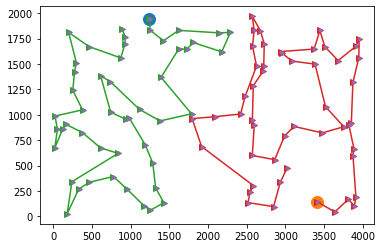






 30%|███       | 30/100 [03:12<07:03,  6.05s/it]

{0: array([16, 14, 61, 76, 59, 22, 97, 44, 90, 46, 31, 83, 98, 35, 37, 23, 17,
       78, 93, 69, 21, 15, 87, 52, 18, 74, 65, 25, 64,  3, 96, 55, 79, 30,
       88, 41,  7, 91, 92,  0, 62,  5, 48, 89,  9, 71, 20, 58, 73, 10]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 28837.8512510344


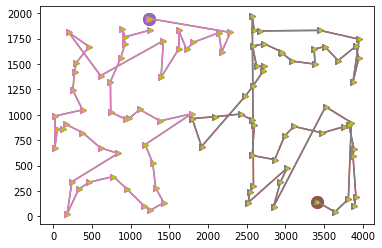

New best distance: 28834.121248244894, changed 83 with 9 on internal
New best distance: 28780.339984233688, changed 29 with 75 on internal
New best distance: 28738.360990724963, changed 26 with 34 on internal
New best distance: 28704.91041580122, changed 61 with 59 on internal
New best distance: 28420.106323098866, changed 51 with 95 on internal
New best distance: 28412.203911165016, changed 12 with 77 on internal
New best distance: 28411.395194146877, changed 68 with 85 on internal
New best distance: 28139.382972304476, changed 50 with 80 on internal
New best distance: 27932.04718853288, changed 68 with 24 on internal
New best distance: 27900.404028870333, changed 80 with 85 on internal
New best distance: 27570.4688059001, changed 40 with 70 on internal
New best distance: 27518.189183116843, changed 20 with 73 on internal
New best distance: 27483.935951871732, changed 77 with 51 on internal
New best distance: 27347.145614204477, changed 75 with 38 on internal
New best distance: 27314.

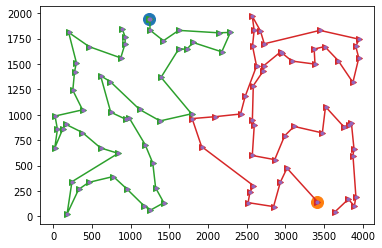






 31%|███       | 31/100 [03:18<06:49,  5.93s/it]

{0: array([98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 97, 44, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 75, 32, 12, 94, 81, 88,
       30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87, 15, 93, 21, 69]), 1: array([47, 99, 34, 76, 22, 59, 61, 85, 26,  1, 43, 49, 29, 51, 36,  4, 77,
       95, 38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50,
       86,  8,  6, 56, 19, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}
Initial distance: 32319.91680347775


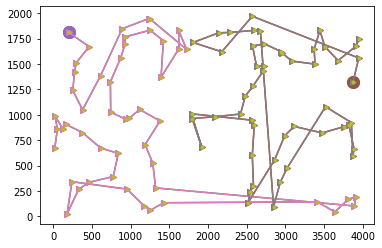

New best distance: 32318.42633996444, changed 41 with 81 on internal
New best distance: 32269.81459505316, changed 51 with 95 on internal
New best distance: 32246.412712146193, changed 99 with 56 on internal
New best distance: 32162.100709231418, changed 56 with 1 on internal
New best distance: 32132.873818753367, changed 99 with 86 on internal
New best distance: 32130.70867546027, changed 55 with 3 on internal
New best distance: 32130.551976335628, changed 99 with 33 on internal
New best distance: 32015.682945911347, changed 49 with 36 on internal
New best distance: 31997.797894339747, changed 81 with 75 on internal
New best distance: 31993.12462272923, changed 26 with 56 on internal
New best distance: 31656.644085613603, changed 24 with 66 on internal
New best distance: 31402.380663528424, changed 15 with 69 on internal
New best distance: 31345.70526313934, changed 56 with 86 on internal
New best distance: 31182.762846869005, changed 11 with 26 on internal
New best distance: 31139.16

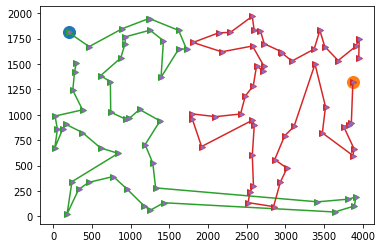






 32%|███▏      | 32/100 [03:25<07:03,  6.23s/it]

{0: array([75, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47, 99, 70,
       13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 92, 27, 57,
       60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 12, 81, 94]), 1: array([93, 69, 21, 15, 87, 83, 58, 16, 14, 61, 76, 59, 22, 97, 44, 90, 46,
       31, 10, 73, 20, 71,  9, 89, 48,  5, 62, 66,  0, 91,  7, 41, 88, 30,
       79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17, 23, 37, 35, 98])}
Initial distance: 29534.608876335733


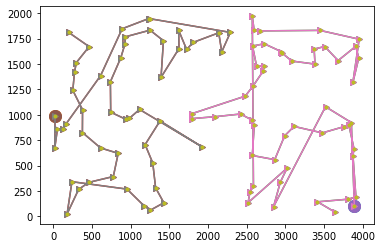

New best distance: 29528.53182895605, changed 63 with 24 on internal
New best distance: 29342.21002464988, changed 11 with 34 on internal
New best distance: 29324.573746217564, changed 51 with 77 on internal
New best distance: 29289.8748616288, changed 93 with 21 on internal
New best distance: 29124.504310972818, changed 62 with 0 on internal
New best distance: 29086.51872239683, changed 50 with 24 on internal
New best distance: 29065.730050616938, changed 55 with 64 on internal
New best distance: 29049.123356205248, changed 77 with 29 on internal
New best distance: 28893.403474293944, changed 14 with 44 on internal
New best distance: 28888.695637404653, changed 75 with 77 on internal
New best distance: 28866.76107718976, changed 55 with 25 on internal
New best distance: 28816.868148681533, changed 6 with 54 on internal
New best distance: 28797.67895714662, changed 75 with 95 on internal
New best distance: 28785.58639009879, changed 40 with 99 on internal
New best distance: 28545.57616

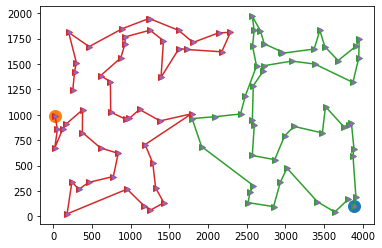






 33%|███▎      | 33/100 [03:32<07:09,  6.41s/it]

{0: array([98, 35, 37, 23, 93, 69, 21, 15, 87, 83, 58, 16, 14, 61, 76, 59, 22,
       97, 44, 90, 46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62, 92,  0, 91,
        7, 41, 88, 30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 78, 17]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 29445.14013649981


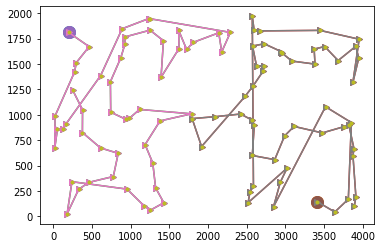

New best distance: 29353.691745310323, changed 63 with 50 on internal
New best distance: 29322.023587063082, changed 14 with 97 on internal
New best distance: 29319.563400155468, changed 23 with 78 on internal
New best distance: 29083.18531620912, changed 12 with 75 on internal
New best distance: 28400.7717660399, changed 53 with 1 on internal
New best distance: 28397.74566095313, changed 44 with 59 on internal
New best distance: 28246.970330217224, changed 59 with 61 on internal
New best distance: 28239.021779792514, changed 35 with 17 on internal
New best distance: 28221.3855013602, changed 4 with 29 on internal
New best distance: 28090.913432024285, changed 29 with 84 on internal
New best distance: 28074.30673761259, changed 4 with 95 on internal
New best distance: 27744.371514642356, changed 13 with 47 on internal
New best distance: 27724.990853225878, changed 29 with 51 on internal
New best distance: 27705.82677244746, changed 14 with 46 on internal
New best distance: 27674.062368

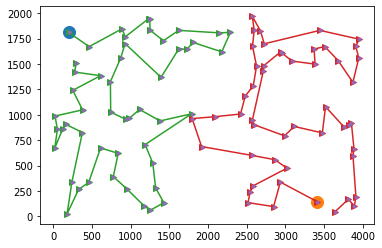






 34%|███▍      | 34/100 [03:38<07:02,  6.40s/it]

{0: array([51, 94, 12, 36, 95, 38, 84,  1, 43, 49, 53, 39, 63, 34, 76, 44, 22,
       59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11,
       19, 56,  6,  8, 86, 50, 92, 66, 27, 57, 60, 24, 80, 68, 72, 67]), 1: array([98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97,
       90, 46, 31, 10, 73, 20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88,
       30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87, 15, 69, 21, 93])}
Initial distance: 34050.33034405976


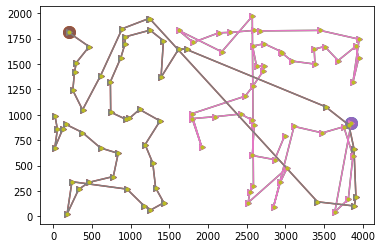

New best distance: 33761.76151171964, changed 51 with 95 on internal
New best distance: 33709.86874692561, changed 84 with 68 on internal
New best distance: 33690.66998501538, changed 14 with 62 on internal
New best distance: 33688.504841722286, changed 55 with 3 on internal
New best distance: 33125.38159334773, changed 14 with 31 on internal
New best distance: 32907.58528108105, changed 27 with 92 on internal
New best distance: 32815.32637014103, changed 94 with 75 on external
New best distance: 32788.606885531175, changed 95 with 4 on external
New best distance: 32784.76961757995, changed 64 with 65 on internal
New best distance: 32015.075045143105, changed 84 with 34 on internal
New best distance: 31991.017554970294, changed 50 with 60 on internal
New best distance: 31714.287313615943, changed 84 with 67 on internal
New best distance: 31566.843232170082, changed 19 with 34 on internal
New best distance: 31532.282801778965, changed 75 with 32 on external
New best distance: 31496.3420

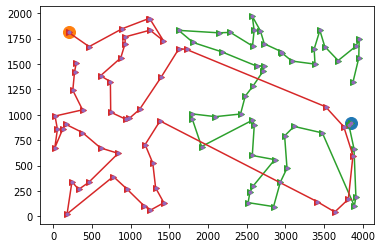






 35%|███▌      | 35/100 [03:43<06:30,  6.01s/it]

{0: array([76, 44, 22, 59,  1, 43, 49, 51, 94, 12, 36, 95, 38, 84, 67, 72, 53,
       39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50, 86,  8,  6, 56, 19, 42,
       40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 26, 34, 85, 61]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34798.20123563371


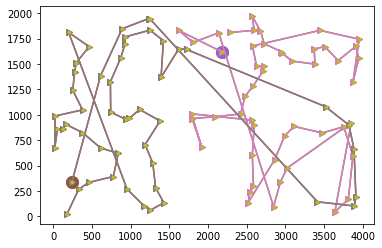

New best distance: 34521.0290760115, changed 59 with 24 on internal
New best distance: 34429.84581337443, changed 51 with 32 on external
New best distance: 34304.44039103713, changed 49 with 81 on external
New best distance: 34258.08866856073, changed 65 with 18 on internal
New best distance: 34217.91400395922, changed 31 with 49 on internal
New best distance: 34071.78714644852, changed 37 with 98 on internal
New best distance: 34054.1406096151, changed 51 with 77 on internal
New best distance: 34027.35792153562, changed 39 with 1 on internal
New best distance: 33958.87123191481, changed 76 with 59 on internal
New best distance: 33833.90676425355, changed 81 with 12 on internal
New best distance: 33830.11935099989, changed 35 with 89 on internal
New best distance: 33417.160385787945, changed 36 with 75 on external
New best distance: 33346.03393047307, changed 44 with 61 on internal
New best distance: 33088.586736685946, changed 57 with 66 on internal
New best distance: 32690.1264406380

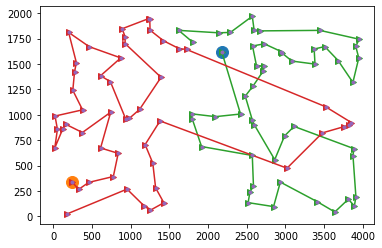






 36%|███▌      | 36/100 [03:50<06:41,  6.28s/it]

{0: array([61, 76, 59, 22, 97, 44, 16, 14, 83, 98, 35, 37, 23, 17, 78, 93, 69,
       21, 15, 87, 52, 18, 74, 65, 25, 64,  3, 96, 55, 79, 30, 88, 41,  7,
       91, 92,  0, 62,  5, 48, 89,  9, 71, 20, 58, 73, 10, 46, 31, 90]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 28879.429799493017


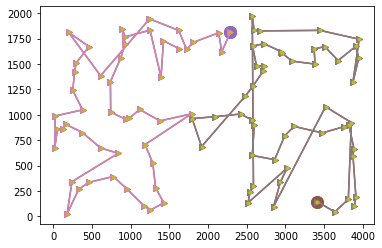

New best distance: 28841.241811652748, changed 63 with 86 on internal
New best distance: 28823.605533220427, changed 51 with 77 on internal
New best distance: 28141.19198305121, changed 53 with 1 on internal
New best distance: 28106.426861764707, changed 94 with 75 on internal
New best distance: 28045.770784417688, changed 32 with 12 on internal
New best distance: 27953.457428693695, changed 12 with 29 on internal
New best distance: 27943.819868178172, changed 22 with 90 on internal
New best distance: 27715.83195972121, changed 12 with 36 on internal
New best distance: 27691.7744695484, changed 24 with 66 on internal
New best distance: 27661.150816246027, changed 10 with 83 on internal
New best distance: 27624.103302801257, changed 50 with 85 on internal
New best distance: 27387.043511961874, changed 95 with 29 on internal
New best distance: 27150.831163298404, changed 63 with 72 on internal
New best distance: 27071.52943338993, changed 20 with 73 on internal
New best distance: 27070.2

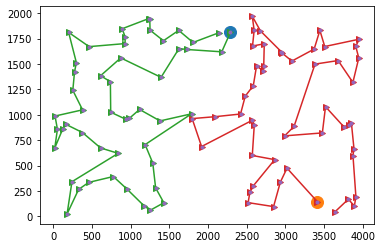






 37%|███▋      | 37/100 [03:58<06:55,  6.59s/it]

{0: array([34, 76, 44, 22, 59, 61, 85, 26, 42, 40, 47, 99, 70, 13,  2, 45, 28,
       33, 82, 54, 11, 19, 56,  6,  1, 43, 49, 51, 94, 12, 36, 95, 38, 84,
       67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50, 86,  8]), 1: array([65, 83, 58, 16, 14, 81, 75, 32,  4, 77, 29, 97, 90, 46, 31, 10, 73,
       20, 71,  9, 89, 48,  5, 62,  0, 91,  7, 41, 88, 30, 79, 55, 98, 35,
       37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 96,  3, 64, 25])}
Initial distance: 34965.19110986928


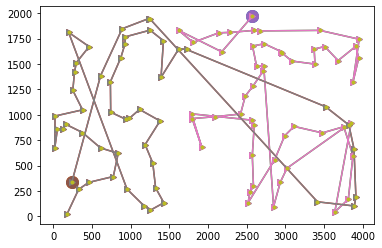

New best distance: 34754.022538351215, changed 94 with 75 on external
New best distance: 34607.89568084052, changed 55 with 35 on internal
New best distance: 34350.63142254516, changed 55 with 96 on internal
New best distance: 34217.24351327249, changed 51 with 81 on external
New best distance: 34183.193690357904, changed 65 with 35 on internal
New best distance: 34026.129962058185, changed 65 with 87 on internal
New best distance: 33981.216808844154, changed 26 with 8 on internal
New best distance: 33723.76961505703, changed 57 with 66 on internal
New best distance: 33549.475930737695, changed 29 with 94 on internal
New best distance: 33507.04423096132, changed 26 with 6 on internal
New best distance: 32836.16877912998, changed 6 with 72 on internal
New best distance: 32710.773273999162, changed 72 with 29 on external
New best distance: 32565.568403492838, changed 75 with 94 on external
New best distance: 32563.294791424618, changed 24 with 57 on internal
New best distance: 32456.1826

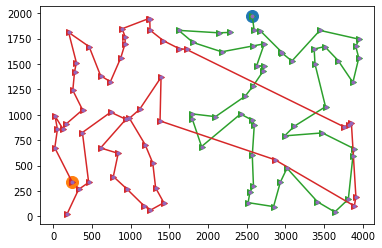






 38%|███▊      | 38/100 [04:04<06:41,  6.48s/it]

{0: array([83, 58, 16, 14, 61, 76, 59, 22, 97, 44, 90, 46, 31, 10, 73, 20, 71,
        9, 89, 48,  5, 98, 35, 37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18,
       74, 65, 25, 64,  3, 96, 55, 79, 30, 88, 41,  7, 91, 92,  0, 62]), 1: array([81, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}
Initial distance: 29772.730778794765


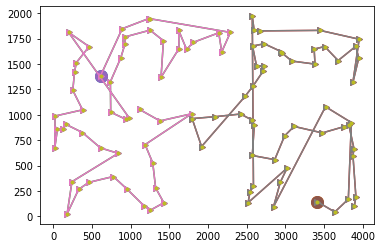

New best distance: 29681.28238760528, changed 63 with 50 on internal
New best distance: 29668.267527447446, changed 34 with 80 on internal
New best distance: 29338.33230447721, changed 13 with 47 on internal
New best distance: 29335.475917674208, changed 34 with 24 on internal
New best distance: 29282.364593741033, changed 63 with 60 on internal
New best distance: 29211.03634786267, changed 24 with 56 on internal
New best distance: 29148.058326054448, changed 9 with 5 on internal
New best distance: 29105.56016773214, changed 26 with 34 on internal
New best distance: 29072.10959280839, changed 61 with 59 on internal
New best distance: 28894.723899392397, changed 63 with 66 on internal
New best distance: 28867.34343800665, changed 86 with 56 on internal
New best distance: 28711.623556095346, changed 14 with 44 on internal
New best distance: 28561.334581545114, changed 29 with 84 on internal
New best distance: 28556.292036513667, changed 60 with 24 on internal
New best distance: 28439.802

KeyboardInterrupt: 

In [181]:
#MAIN - tu poskladac wyzej zaimplementowane funkcje w 8 roznych kombinacji algorytmow i sprawdzic ich czasy i wyplotowac skutecznosci

timeTable = []
distanceTable = []
bestDistance = 0
for _ in tqdm(range(100)):
    startTime = time()
    distanceTable.append(greedy_search(dista, np_kroa))
    timeTable.append(time() - startTime)
print(f"greedy_search; time:{np.mean(timeTable)}, min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]

random_wandering; time:1.1957372832298279, min:100113.35297990218, max:145550.3294451778, mean:120324.36337005021


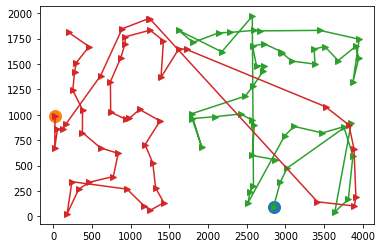

In [47]:
#MAIN - tu poskladac wyzej zaimplementowane funkcje w 8 roznych kombinacji algorytmow i sprawdzic ich czasy i wyplotowac skutecznosci

timeTable = []
distanceTable = []
bestDistance = 0
for _ in tqdm(range(100)):
    startTime = time()
    distanceTable.append(random_wandering(dista, np_kroa, 1))
    timeTable.append(time() - startTime)
print(f"random_wandering; time:{np.mean(timeTable)}, min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


In [48]:
combinations = mesh.T.reshape(-1,2)

NameError: name 'mesh' is not defined

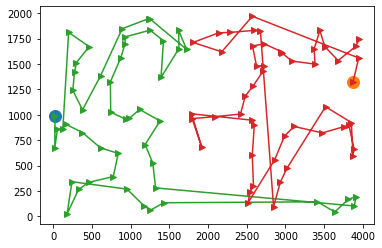

In [56]:
cycles = starty_cycle_heuristic()

In [102]:
mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
combinations = mesh.T.reshape(-1, 2)

In [88]:
random.shuffle(combinations, axis=0)

TypeError: shuffle() got an unexpected keyword argument 'axis'

In [167]:
x = np.array([np.array([1,2,3,4,5,6,7,8,9]), np.array([20,30,40])])
change_edges(x, 4, 9)

4 9


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([array([1, 2, 3, 4, 9, 8, 7, 6, 5]), array([20, 30, 40])],
      dtype=object)

In [149]:
change_edges(x, 2, 3)

array([array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([20, 30, 40])],
      dtype=object)

In [148]:
x

array([array([0, 1, 2, 6, 5, 4, 3, 7, 8, 9]), array([20, 30, 40])],
      dtype=object)

In [94]:
random.sample(x,3)

TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [108]:
i = np.random.choice(range(len(x)),len(x),replace=False)

In [112]:
mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
combinations = mesh.T.reshape(-1, 2)
i = np.random.choice(range(len(combinations)),len(combinations),replace=False)
combinations = combinations[i]
possible_moves = {'external': [combinations]}

mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
combinations = mesh.T.reshape(-1, 2)
i = np.random.choice(range(len(combinations)),len(combinations),replace=False)
combinations = combinations[i]
possible_moves['internal'] = [combinations]

In [128]:
mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
combinations = mesh.T.reshape(-1, 2)
#         i = np.random.choice(range(len(combinations)),len(combinations),replace=False)
#         combinations = combinations[i]
#         possible_moves = {'external': [combinations]}
possible_moves = []
for x in combinations:
    possible_moves.append(["external", x])

mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
combinations = mesh.T.reshape(-1, 2)
#         i = np.random.choice(range(len(combinations)),len(combinations),replace=False)
#         combinations = combinations[i]
for x in combinations:
    possible_moves.append(["internal", x])

possible_moves = np.array(possible_moves)
i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
possible_moves = possible_moves[i]

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [131]:
x,y = possible_moves[0]

In [132]:
x

'external'

In [133]:
y

array([78, 28])